<a href="https://colab.research.google.com/github/georgerieh/ml-ai-code-studies/blob/main/RNN_Time_Series_101.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


This code was originally taken from
[the source](https://www.codecademy.com/article/rnn-py-torch-time-series-tutorial-complete-guide-to-implementation),
 and adjusted by my own comment snippets, and some code adjustments, in particular, checking different epochs and loading them for the final graph.




In [31]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim


In [32]:
# Generate a sine wave
time_steps = np.linspace(0, 100, 500)   # 500 points between 0 and 100
data = np.sin(time_steps) # Create a sine wave

# Convert to DataFrame
df = pd.DataFrame(data, columns=['value'])


In [33]:
df.head()

,value
0,0.000000
1,0.199062
2,0.390157
3,0.565634
4,0.718472


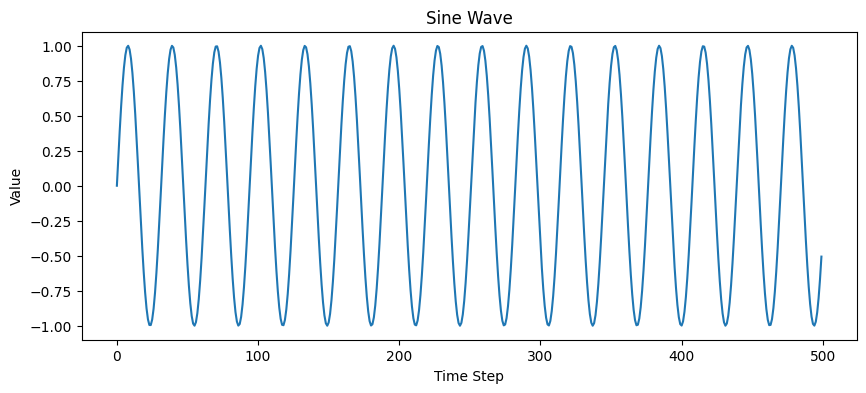

In [34]:
plt.figure(figsize=(10, 4))
plt.plot(df['value'])
plt.title("Sine Wave")
plt.xlabel("Time Step")
plt.ylabel("Value")
plt.show()


In [35]:
scaler = MinMaxScaler()

df['value'] = scaler.fit_transform(df[['value']])  # Normalize values

data = df['value'].values  # Convert to numpy array for sequence creation


In [36]:
data[:5]

array([0.50000039, 0.59953189, 0.69507953, 0.78281887, 0.85923805])

In [37]:
def create_sequences(data, seq_length):
  xs, ys = [], []
  for i in range(len(data) - seq_length):
    x = data[i:i+seq_length] # Sequence of length `seq_length`
    y = data[i+seq_length] # Label is the next value
    xs.append(x)
    ys.append(y)
  return np.array(xs), np.array(ys)

SEQ_LENGTH = 20 # Number of past time steps to look at

X, y = create_sequences(data, SEQ_LENGTH)

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Convert arrays to PyTorch tensors
X_train = torch.Tensor(X_train).unsqueeze(-1) # Shape: (batch, seq, input_size)
y_train = torch.Tensor(y_train)
X_test = torch.Tensor(X_test).unsqueeze(-1)
y_test = torch.Tensor(y_test)


In [38]:
X[:2]
#X is array of arrays

array([[0.50000039, 0.59953189, 0.69507953, 0.78281887, 0.85923805,
        0.92127829, 0.96645636, 0.99296394, 0.99974003, 0.98651342,
        0.95381351, 0.90294916, 0.83595628, 0.75551635, 0.66484906,
        0.56758351, 0.46761285, 0.36893854, 0.27551016, 0.19106727],
       [0.59953189, 0.69507953, 0.78281887, 0.85923805, 0.92127829,
        0.96645636, 0.99296394, 0.99974003, 0.98651342, 0.95381351,
        0.90294916, 0.83595628, 0.75551635, 0.66484906, 0.56758351,
        0.46761285, 0.36893854, 0.27551016, 0.19106727, 0.11898982]])

In [39]:
class BasicRNN(nn.Module):
  #2 essential classes - __init__() and and forward()
  def __init__(self, input_size=1, hidden_size=64, num_layers=1):
    super(BasicRNN, self).__init__()
    self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
    self.fc = nn.Linear(hidden_size, 1)

  def forward(self, x):
    out, _ = self.rnn(x)         # RNN output for all time steps
    out = out[:, -1, :]          # Take output from the last time step
    return self.fc(out)          # Pass through linear layer

# Instantiate the model
model = BasicRNN()


In [40]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

EPOCHS = 100

losses = []
saved_model_paths = []
for epoch in range(EPOCHS):
  model.train()
  output = model(X_train)
  loss = criterion(output.squeeze(), y_train)  # Compute loss

  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  losses.append(loss.item())

  if (epoch + 1) % 10 == 0:
    print(f"Epoch [{epoch+1}/{EPOCHS}], Loss: {loss.item():.4f}")

  # Save model state every 20 epochs
  if (epoch + 1) % 20 == 0:
    path = f"rnn_model_epoch_{epoch+1}.pth"
    torch.save(model.state_dict(), path)
    saved_model_paths.append(path)
    print(f"Saved model checkpoint to {path}")

print("\nTraining complete.")
print(f"Saved models at epochs: {[int(p.split('_')[-1].split('.')[0]) for p in saved_model_paths]}")


Epoch [10/100], Loss: 0.0654
Epoch [20/100], Loss: 0.0078
Saved model checkpoint to rnn_model_epoch_20.pth
Epoch [30/100], Loss: 0.0106
Epoch [40/100], Loss: 0.0019
Saved model checkpoint to rnn_model_epoch_40.pth
Epoch [50/100], Loss: 0.0013
Epoch [60/100], Loss: 0.0005
Saved model checkpoint to rnn_model_epoch_60.pth
Epoch [70/100], Loss: 0.0004
Epoch [80/100], Loss: 0.0003
Saved model checkpoint to rnn_model_epoch_80.pth
Epoch [90/100], Loss: 0.0002
Epoch [100/100], Loss: 0.0002
Saved model checkpoint to rnn_model_epoch_100.pth

Training complete.
Saved models at epochs: [20, 40, 60, 80, 100]


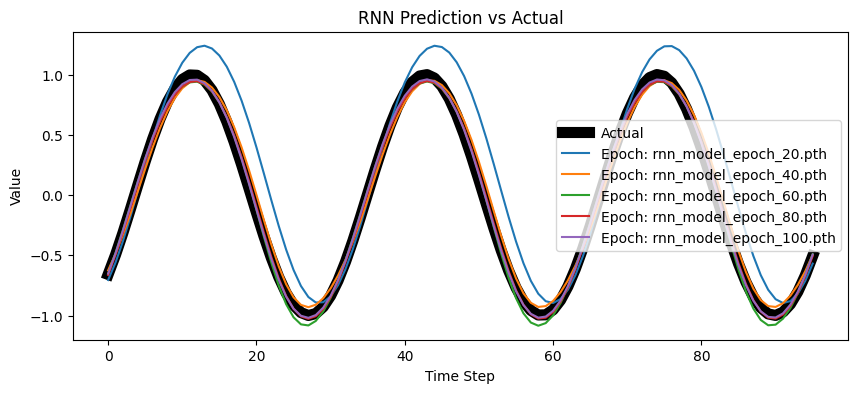

In [47]:
plt.figure(figsize=(10, 4))
plt.title("RNN Prediction vs Actual")
plt.xlabel("Time Step")
plt.ylabel("Value")

for i, model_path in enumerate(saved_model_paths):
  model.load_state_dict(torch.load(model_path, weights_only=True))
  model.eval()
  with torch.no_grad():  #to keep the trained weights, not learning through operations
    predictions = model(X_test).squeeze().numpy() # Predict on test set

  # Inverse transform to original scale
  y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))
  predictions_inv = scaler.inverse_transform(predictions.reshape(-1, 1))


  # Plot actual vs predicted
  #plot actual only once
  if i ==0:
    plt.plot(y_test_inv, label='Actual', linewidth=8, color='black')
  plt.plot(predictions_inv, label=f'Epoch: {model_path}')
plt.legend()
plt.show()


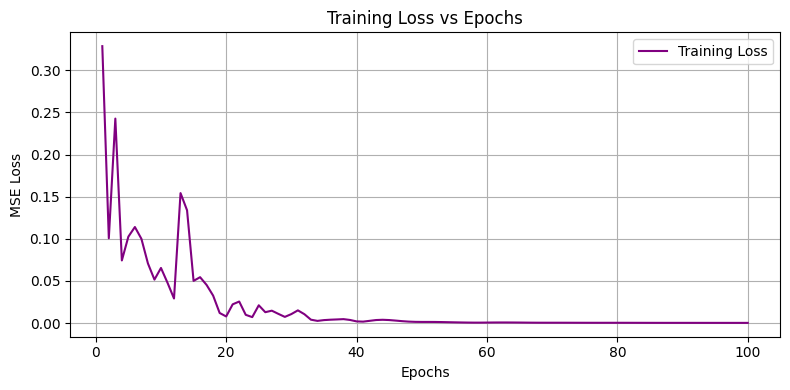

In [44]:
# Plot the loss at each epoch to visualize model convergence
plt.figure(figsize=(8, 4))
plt.plot(range(1, 100 + 1), losses, label='Training Loss', color='purple')
plt.xlabel('Epochs')
plt.ylabel('MSE Loss')
plt.title('Training Loss vs Epochs')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


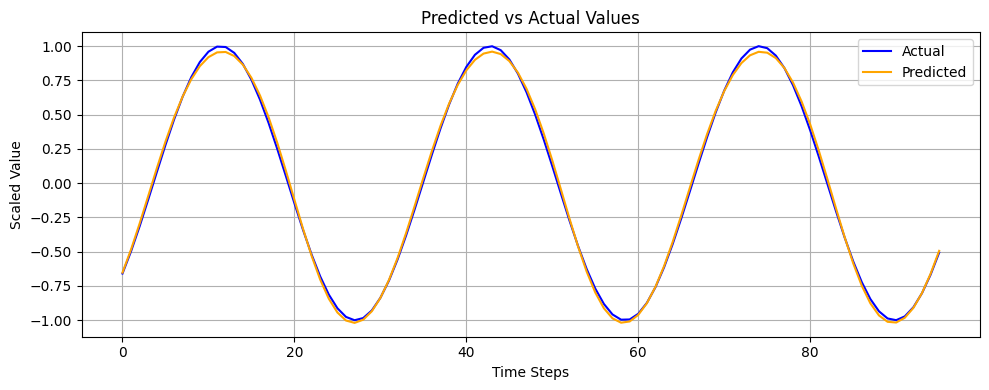

In [45]:
# Plot predictions vs actuals
plt.figure(figsize=(10, 4))
plt.plot(y_test_inv, label='Actual', color='blue')
plt.plot(predictions_inv, label='Predicted', color='orange')
plt.xlabel('Time Steps')
plt.ylabel('Scaled Value')
plt.title('Predicted vs Actual Values')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
